# This file is the final version of movement detection 
### Using PCA and SVM

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
import os
from scipy.stats import skew
from scipy import signal
import matplotlib.pyplot as plt
import joblib
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

# Training stage

### static data feature generation

In [3]:
foldername = '/Users/wanrylin/Master Programme/dataset/movement detection/static'
list_path = os.listdir(foldername)
list_path = [x for x in list_path if 'p_static' in x]
feature_num = 2 # average,variance
dimension_num = 10 # collect first 10 dimensions after PCA

# iterate each static data file
all_feature = np.zeros((1, feature_num*dimension_num))
for file in list_path:
    
    #1. load csi data and only use phase data 
    path = foldername + '/' + file
    CSIdata = pd.read_csv(path)
    CSI_array = CSIdata.values
    time_sequence = CSI_array[:, 0]
    # Vectorized function to convert string to complex
    convert_func = np.vectorize(lambda x: complex(x))
    # Convert string matrix to complex matrix
    csi_slice = convert_func(CSI_array[:, 1:])
    phase = np.angle(csi_slice)
    
    #2. create csi feature
    # create a PCA object with 10 components
    pca = PCA(dimension_num)
    # fit the PCA object to the data and transform the data
    phase_pca = pca.fit_transform(phase)
    # iterate each component
    feature_matrix = np.zeros((feature_num, dimension_num))
    for i in range(dimension_num):
        pha_mean = np.mean(phase_pca[:, i])
        pha_var = np.var(phase_pca[:, i])
        sub_feature = np.array([pha_mean, pha_var])
        feature_matrix[:, i] = sub_feature
    feature_matrix = feature_matrix.T
    feature = feature_matrix.reshape(1, -1)
    all_feature = np.concatenate((all_feature, feature), axis=0)

# save all feature
all_feature = all_feature[1:, :]
feature_df = pd.DataFrame(all_feature)
file_name = foldername + '/p_feature' + '.csv'
feature_df.to_csv(file_name, index=False)

In [4]:
feature_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1.071170e-16,23.564116,-5.355850e-17,1.663969,1.606755e-16,0.131073,8.368515e-17,0.087026,1.405911e-16,0.015247,6.806392e-17,0.010586,-1.790862e-16,0.009208,-9.177472e-17,0.007424,1.115802e-18,0.005233,3.938781e-16,0.003942
1,-9.150929e-16,19.070015,1.794300e-17,1.243541,-9.812577e-17,0.092875,1.682156e-17,0.045825,-3.925031e-17,0.037982,3.498885e-16,0.034273,1.155081e-16,0.014247,-3.207311e-16,0.010701,-1.541976e-16,0.005068,-1.940087e-16,0.003679
2,2.499397e-16,21.242101,-1.383595e-16,0.430106,6.025331e-17,0.051502,-6.360072e-17,0.021458,6.862183e-17,0.012059,-3.571961e-16,0.006964,-1.311067e-16,0.004881,2.603741e-16,0.003396,-5.579010e-18,0.003038,-8.846218e-17,0.002312
3,2.389516e-16,24.014911,-3.606816e-17,1.425486,-3.888598e-16,0.121965,3.516646e-16,0.091474,-8.228049e-17,0.072786,2.186632e-16,0.063636,1.758323e-16,0.052236,1.792137e-16,0.028499,3.634994e-16,0.025449,1.780865e-16,0.022771
4,8.881784e-17,18.534323,-7.771561e-18,0.010211,-8.631984e-17,0.009092,-6.550316e-17,0.008107,1.310063e-16,0.005186,-5.773160e-17,0.002723,-6.453171e-17,0.002617,-8.659740e-17,0.002328,1.508516e-16,0.001543,5.884182e-17,0.001353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366,2.454764e-16,18.983649,-1.428227e-16,1.488793,1.562123e-16,0.132719,-1.983338e-16,0.052286,-9.372737e-17,0.019540,-1.673703e-16,0.016817,2.867611e-16,0.009834,1.405911e-16,0.009506,-1.295725e-16,0.006993,-4.463208e-17,0.005928
367,-1.930823e-16,19.620186,1.448117e-17,0.591175,8.688702e-17,0.109257,3.113452e-16,0.067261,-2.654881e-17,0.062905,-1.834282e-16,0.049309,-1.025750e-16,0.014951,-2.274750e-16,0.010161,-1.644216e-17,0.006019,-2.148040e-16,0.005261
368,-1.983749e-16,22.463803,1.690695e-16,0.921094,-2.017563e-16,0.315610,1.014417e-17,0.044681,5.861076e-17,0.035157,6.875493e-17,0.010721,-1.352556e-16,0.008709,-2.485322e-16,0.005811,-2.772740e-16,0.004167,-1.555439e-16,0.003598
369,3.927623e-16,21.649597,-3.124246e-17,1.403603,-1.199487e-17,0.047935,-1.093486e-16,0.039099,1.433806e-16,0.010215,3.012665e-16,0.004868,1.417069e-16,0.003551,-9.679583e-17,0.002979,-3.336248e-16,0.002638,4.184258e-17,0.002340


### dynamic data feature generation

In [5]:
foldername = '/Users/wanrylin/Master Programme/dataset/movement detection/dynamic'
list_path = os.listdir(foldername)
list_path = [x for x in list_path if 'dynamic' in x]
feature_num = 2 # average,variance
dimension_num = 10 # collect first 10 dimensions after PCA

# iterate each static data file
all_feature = np.zeros((1, feature_num*dimension_num))
for file in list_path:
    
    #1. load csi data and only use phase data 
    path = foldername + '/' + file
    CSIdata = pd.read_csv(path)
    CSI_array = CSIdata.values
    time_sequence = CSI_array[:, 0]
    # Vectorized function to convert string to complex
    convert_func = np.vectorize(lambda x: complex(x))
    # Convert string matrix to complex matrix
    csi_slice = convert_func(CSI_array[:, 1:])
    phase = np.angle(csi_slice)
    
    #2. create csi feature
    # create a PCA object with 10 components
    pca = PCA(dimension_num)
    # fit the PCA object to the data and transform the data
    phase_pca = pca.fit_transform(phase)
    # iterate each component
    feature_matrix = np.zeros((feature_num, dimension_num))
    for i in range(dimension_num):
        pha_mean = np.mean(phase_pca[:, i])
        pha_var = np.var(phase_pca[:, i])
        sub_feature = np.array([pha_mean, pha_var])
        feature_matrix[:, i] = sub_feature
    feature_matrix = feature_matrix.T
    feature = feature_matrix.reshape(1, -1)
    all_feature = np.concatenate((all_feature, feature), axis=0)

# save all feature
all_feature = all_feature[1:, :]
feature_df = pd.DataFrame(all_feature)
file_name = foldername + '/all_feature' + '.csv'
feature_df.to_csv(file_name, index=False)

In [6]:
feature_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,7.105427e-17,32.846442,-1.865175e-16,3.895003,-1.776357e-17,1.636667,3.463896e-16,1.325940,-3.552714e-17,1.021010,-7.216450e-17,0.613142,-1.798561e-16,0.558792,-2.220446e-16,0.436230,-3.552714e-16,0.423309,-1.332268e-17,0.319534
1,-2.398082e-16,12.129902,-1.421085e-16,6.945776,-1.065814e-16,6.011744,-1.598721e-16,1.729823,0.000000e+00,1.428150,1.332268e-17,0.862343,-1.376677e-16,0.586690,-1.065814e-16,0.525981,5.773160e-17,0.367125,-3.330669e-17,0.338598
2,2.164090e-16,19.817826,-3.787157e-16,1.841662,3.606816e-16,1.086711,-1.938664e-16,0.719824,3.606816e-17,0.422886,1.442726e-16,0.280780,4.508520e-17,0.237463,-2.254260e-17,0.137688,-1.532897e-16,0.080740,-1.803408e-16,0.067111
3,2.131628e-16,24.190847,-1.243450e-16,1.378359,-3.552714e-17,1.112579,8.604228e-17,0.564226,-1.154632e-16,0.354600,-9.325873e-17,0.167531,8.881784e-17,0.138405,1.909584e-16,0.079842,-3.663736e-17,0.045023,-3.552714e-17,0.037889
4,-3.095167e-16,23.694344,3.588600e-17,1.842471,1.906444e-16,1.302764,1.973730e-16,0.792529,6.728624e-17,0.602834,-1.872800e-16,0.475161,-1.928872e-16,0.318926,1.076580e-16,0.296571,1.884015e-16,0.223037,1.300867e-16,0.185024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,-5.355850e-16,20.542000,-2.856453e-16,1.551869,1.249698e-16,0.691720,2.343184e-17,0.188400,1.525859e-16,0.140806,4.206574e-16,0.131624,-1.389174e-16,0.078284,5.899803e-17,0.029014,3.347406e-18,0.014260,-7.587454e-17,0.011303
123,-1.450087e-16,22.714007,-7.250436e-17,0.357538,3.965082e-17,0.070203,-5.140446e-17,0.044883,-1.336799e-16,0.015022,-2.101494e-16,0.010321,-2.209117e-17,0.006700,-3.200388e-17,0.004929,-9.091367e-17,0.003408,2.664040e-18,0.002523
124,-1.785283e-16,15.288692,-1.785283e-16,1.058375,1.562123e-16,0.660979,2.186972e-16,0.330992,-8.033775e-17,0.275713,2.231604e-16,0.206348,1.115802e-18,0.143673,-2.499397e-16,0.130936,4.463208e-17,0.093081,4.909529e-17,0.057816
125,-1.421085e-16,35.387977,8.881784e-18,3.365012,-1.776357e-17,1.741263,6.217249e-17,1.485274,1.065814e-16,0.825351,-5.551115e-17,0.690933,-2.953193e-16,0.599731,2.220446e-17,0.440756,-2.220446e-17,0.371887,5.995204e-17,0.339736


# Train SVM model

In [28]:
## load feature
static = pd.read_csv('/Users/wanrylin/Master Programme/dataset/movement detection/static/all_feature.csv')
dynamic = pd.read_csv('/Users/wanrylin/Master Programme/dataset/movement detection/dynamic/all_feature.csv')
svm_folder = '/Users/wanrylin/Master Programme/dataset/movement detection/svm_model'
static_array = static.values
dynamic_array = dynamic.values
feature_num = 2
dimension_num = 10
performance = np.zeros((dimension_num,4))
contribution = np.zeros((dimension_num,feature_num))

# generate data set and label
static_feature = static_array[:,:]
static_label = np.zeros((len(static_feature),1))
dynamic_feature = dynamic_array[:,:]
dynamic_label = np.ones((len(dynamic_feature),1))
data = np.concatenate((static_feature,dynamic_feature),axis = 0)
label = np.ravel(np.concatenate((static_label,dynamic_label),axis = 0))
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.3, random_state=42)
# Create an instance of StandardScaler
scaler = StandardScaler()
# Fit the scaler to the data and transform it
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train SVM
svc = SVC(kernel='linear', C=0.1)
svc.fit(X_train_scaled, y_train)

# Predict labels of test set
y_pred = svc.predict(X_test_scaled)

# verify the performance
Accuracy = accuracy_score(y_test, y_pred)
Precision = precision_score(y_test, y_pred)
Recall = recall_score(y_test, y_pred)
F1_score = f1_score(y_test, y_pred)
print([Accuracy,Precision,Recall,F1_score])
# contribution = abs(svc.coef_[0])
# print(contribution.argsort())
# print(np.sort(contribution))

[0.98, 1.0, 0.9285714285714286, 0.962962962962963]


In [20]:
from sklearn.ensemble import RandomForestClassifier

# Train RM
rm = RandomForestClassifier(n_estimators=20, max_depth=5, random_state=42)
rm.fit(X_train_scaled, y_train)

# Predict labels of test set
y_pred = rm.predict(X_test_scaled)

# verify the performance
Accuracy = accuracy_score(y_test, y_pred)
Precision = precision_score(y_test, y_pred)
Recall = recall_score(y_test, y_pred)
F1_score = f1_score(y_test, y_pred)
print([Accuracy,Precision,Recall,F1_score])

[0.9533333333333334, 0.9069767441860465, 0.9285714285714286, 0.9176470588235294]


In [22]:
from sklearn.neighbors import KNeighborsClassifier

# Train KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

# Predict labels of test set
y_pred = knn.predict(X_test_scaled)

# verify the performance
Accuracy = accuracy_score(y_test, y_pred)
Precision = precision_score(y_test, y_pred)
Recall = recall_score(y_test, y_pred)
F1_score = f1_score(y_test, y_pred)
print([Accuracy,Precision,Recall,F1_score])

[0.9333333333333333, 0.8809523809523809, 0.8809523809523809, 0.8809523809523809]


In [24]:
from sklearn.linear_model import LogisticRegression

# Train LR
# Create a logistic regression classifier
lr = LogisticRegression(penalty='l2', C=0.1, solver='lbfgs', max_iter=500)
lr.fit(X_train_scaled, y_train)

# Predict labels of test set
y_pred = lr.predict(X_test_scaled)

# verify the performance
Accuracy = accuracy_score(y_test, y_pred)
Precision = precision_score(y_test, y_pred)
Recall = recall_score(y_test, y_pred)
F1_score = f1_score(y_test, y_pred)
print([Accuracy,Precision,Recall,F1_score])

[0.9466666666666667, 0.9473684210526315, 0.8571428571428571, 0.9]


In [25]:
from sklearn.naive_bayes import GaussianNB

# Train NB
gnb = GaussianNB()
gnb.fit(X_train_scaled, y_train)

# Predict labels of test set
y_pred = gnb.predict(X_test_scaled)

# verify the performance
Accuracy = accuracy_score(y_test, y_pred)
Precision = precision_score(y_test, y_pred)
Recall = recall_score(y_test, y_pred)
F1_score = f1_score(y_test, y_pred)
print([Accuracy,Precision,Recall,F1_score])

[0.9466666666666667, 0.8863636363636364, 0.9285714285714286, 0.9069767441860465]


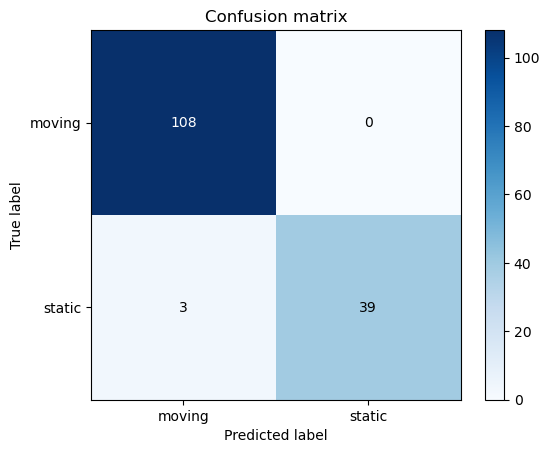

In [8]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Display the confusion matrix as an image
fig, ax = plt.subplots()
im = ax.imshow(cm, cmap='Blues')
ax.set_title('Confusion matrix')
fig.colorbar(im)
tick_marks = np.arange(2)
ax.set_xticks(tick_marks)
ax.set_yticks(tick_marks)
target_names = ['moving','static']
ax.set_xticklabels(target_names)
ax.set_yticklabels(target_names)
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
# Display the numbers of predicted label in the confusion matrix
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

plt.show()

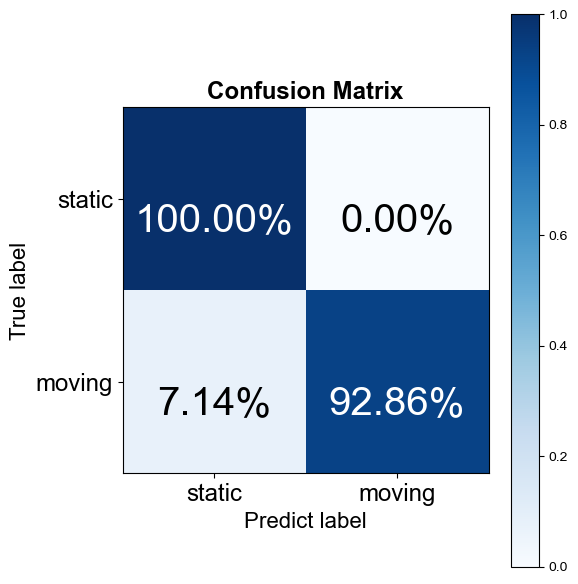

The accuracy of the model is 98.00%
The GMean of the model is 96.36%
The recall of the model is 100.00%
The precision of the model is 98.00%
The F1 of the model is 98.99%


In [69]:
from matplotlib import rcParams
from math import log
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
# plot confusion matrix
def confusion_m(predicted, true,person):
    
    # generate confusion matrix
    cm = confusion_matrix(true,predicted, labels = person)
#     person = [0,1,2,3,4]
    
    # get proportion of every grid
    proportion=[]
    for i in cm:
        for j in i:
            temp=j/(np.sum(i))
            proportion.append(temp)

    # generate the percentage
    percentage=[]
    for i in proportion:
        pt="%.2f%%" % (i * 100)
        percentage.append(pt)
        
    proportion=np.array(proportion).reshape(len(person),len(person))  
    percentage=np.array(percentage).reshape(len(person),len(person))
    
    # set the font
    config = {"font.family":'Arial'}
    rcParams.update(config)
    
    #
    # plot the confusion matrix
    #
    fs = int( 9 / log(len(person),10) )
    fig = plt.figure( figsize=(6,6) )
    plt.imshow(proportion, interpolation='nearest', cmap=plt.cm.Blues)  
                # ('Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds','YlOrBr', 'YlOrRd',
                # 'OrRd', 'PuRd', 'RdPu', 'BuPu','GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn')
    plt.title('Confusion Matrix',fontsize='xx-large',fontweight='heavy')
    plt.colorbar()
    tick_marks = np.arange(len(person))
    plt.xticks(tick_marks, person,fontsize = 'xx-large')
    plt.yticks(tick_marks, person,fontsize = 'xx-large')

    # plot the percentage
    thresh = cm.max() / 2.
    iters = np.reshape([[[i,j] for j in range(len(person))] for i in range(len(person))],(cm.size,2))
    for i, j in iters:
        if(i==j):
#             plt.text(j, i - 0.12, format(cm[i, j]), va='center', ha='center',color='white',weight=5,fontsize=fs)  
            plt.text(j, i + 0.12, percentage[i, j], va='center', ha='center',color='white',fontsize=fs)
        else:
#             plt.text(j, i-0.12, format(cm[i, j]),va='center',ha='center',fontsize=fs)   
            plt.text(j, i+0.12, percentage[i, j], va='center', ha='center',fontsize=fs)

    plt.ylabel('True label',fontsize=16)
    plt.xlabel('Predict label',fontsize=16)
    plt.tight_layout()
    plt.show()
    
    total = len(predicted)
    # calculate accuarcy
    TP_m = np.sum(cm * np.eye(len(person)).astype(int),axis = 1)
    TP = np.sum(TP_m)
    accuracy = np.sum(TP_m) / total 
    print('\033[31mThe accuracy of the model is %.2f%%\033[0m' % (accuracy * 100))
    
    # calculate GMean
    gm = np.sqrt(np.prod([cm.diagonal()/np.sum(cm, axis=1)]))
    print('\033[31mThe GMean of the model is %.2f%%\033[0m' % (gm * 100))
    
    # calculate recall
    FN = np.sum(np.triu(cm, k = 1))
    recall = TP / ( TP + FN )
    print('The recall of the model is %.2f%%' % (recall * 100))
    
    # calculate precision
    FP = np.sum(np.tril(cm, k = -1))
    precision = TP / ( TP + FP )
    print('The precision of the model is %.2f%%' % (precision * 100))
    
    # calculate F1
    F1 = 2 * recall * precision / ( recall + precision )
    print('The F1 of the model is %.2f%%' % (F1 * 100))

Motion_label = ['static','moving']
pred_label = [Motion_label[int(x)] for x in y_pred]
true_label = [Motion_label[int(x)] for x in y_test]

confusion_m(pred_label, true_label,Motion_label)

In [12]:
y_pred

array([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.])

# store SVM model

In [109]:
# Save the trained SVM model and scaler model
filename = svm_folder + '/pca_scaler.joblib'
joblib.dump(scaler, filename)
filename = svm_folder + '/pca_svm_model.joblib'
joblib.dump(svc, filename)

['/Users/wanrylin/Master Programme/dataset/movement detection/svm_model/pca_svm_model.joblib']

# Test the SVM in original CSI sequence
try to find the start and end of the movement

In [28]:
moving_num = 0

In [47]:
#1. load CSI data and SVM model
svm_folder = '/Users/wanrylin/Master Programme/dataset/movement detection/svm_model'
bkbg_folder = '/Users/wanrylin/Master Programme/dataset/original data/blankbackground'
movement_folder = '/Users/wanrylin/Master Programme/dataset/original data/movement'
movement_listpath = os.listdir(movement_folder)
# load svm model
filename = svm_folder + '/pca_svm_model.joblib'
svm = joblib.load(filename)
filename = svm_folder + '/pca_scaler.joblib'
scaler = joblib.load(filename)
# Load the csi sequence
# filename = bkbg_folder + '/bkbg2.csv'
filename = movement_folder + '/' + movement_listpath[moving_num]
CSIdata = pd.read_csv(filename)
CSI_array = CSIdata.values
time_sequence = CSI_array[1:,0]
csi_data_str = CSI_array[1:,1:]
# change str into complex
csi_data = np.zeros_like(csi_data_str, dtype=np.complex64)
[row,col] = csi_data_str.shape
for i in range(row):
    for j in range(col):
        element = csi_data_str[i,j]
        element = element.replace('i', 'j')
        csi_data[i,j] = complex(element)

#2. revise CSI data
#(a) adjust time sequence that make the time sequence number in order
peak = [ time_sequence[t] for t in range(1,len(time_sequence)-1) if time_sequence[t] > time_sequence[t-1] and time_sequence[t] > time_sequence[t+1]]
peak = []
for i in range(1,len(time_sequence)-1):
    if time_sequence[i] > time_sequence[i-1] and time_sequence[i] > time_sequence[i+1]:
        peak.append(i)
for position in peak:
    time_sequence[int(position+1):] += 4096 
time_sequence -= (time_sequence[0]-1)
# check time sequence is it in order
flag = 0
for i in range(1,len(time_sequence)-1):
    if time_sequence[i] < time_sequence[i-1]: 
        flag = 1
        print("the %d in time sequence not in order",i)
        break
#(b) phase correction from [IndoTrack]
rx1 = csi_data[:,:57]
rx2 = csi_data[:,57:]
csi_data_adj = np.zeros(rx1.shape, dtype=complex)
csi_data_ref_adj = np.zeros(rx2.shape, dtype=complex)
alpha_sum = 0
for jj in range(57):
    amp = np.abs(rx1[:,jj])
    alpha = np.min(amp[amp!=0])
    alpha_sum = alpha_sum + alpha
    csi_data_adj[:,jj] = np.abs(np.abs(rx1[:,jj]) - alpha) * np.exp(1j * np.angle(rx1[:,jj]))
beta = 5000 * alpha_sum / 57 # 5000 is an experience value, it just need to be large enough
for jj in range(57):
    csi_data_ref_adj[:,jj] = (np.abs(rx2[:,jj]) + beta) * np.exp(1j * np.angle(rx2[:,jj]))
# Conjunction Multiply
conj_mult = csi_data_adj * np.conj(csi_data_ref_adj)
csi_revised = np.zeros(conj_mult.shape, dtype=complex)
for j in range(57):
    for i in range(len(conj_mult)):
        z = conj_mult[i,j]
        if z.imag < 0:
            csi_revised[i,j] = -1 * z.real + (-1j) * z.imag
        else:
            csi_revised[i,j] = z           
csi_phase = np.angle(csi_revised)
csi_amp = np.abs(csi_revised)

#3. movement period detection
feature_num = 2
dimension_num = 10
# cut the csi sequence into frame with 1 second long and 0.5 interval
sampling_rate = 200 # Hz
frame_length = 1 # second
frame = frame_length * sampling_rate
interval_length = 0.5 # second
interval = interval_length * sampling_rate
time_sequence = list(time_sequence)
num = int((time_sequence[-1] - frame)/interval + 1) # number of frames
start = 0 # initial boundry
end = 150
labels = np.zeros((num,))
colors = list(np.zeros((len(csi_amp))))
# prediction for each frame
for i in range(num):
    #1. generate frame
    if (i * interval + 1) in time_sequence:
        start = int(time_sequence.index(i * interval + 1))
    else:
        start_time = np.min([x for x in time_sequence[start:start + 200] if x > (i * interval + 1)])
        start = int(time_sequence.index(start_time))
    if (i * interval + frame + 1) in time_sequence or (i * interval + frame + 1) > time_sequence[-1]:
        end = int(time_sequence.index(np.min([i * interval + frame + 1,time_sequence[-1]])))
    else:
        end_time = np.min([x for x in time_sequence[end:end + 200] if x > (i * interval + frame + 1)])
        end = int(np.min([time_sequence.index(end_time),len(time_sequence)]))
    csi_slice = csi_revised[start:end]
    csi_time = np.array(time_sequence[start:end])
    csi_time = csi_time - csi_time[0]
    csi_time_sequence = np.hstack((np.matrix(csi_time).T,csi_slice))
    phase = np.angle(csi_slice)

    #2. Make predictions on the test set using the loaded model
    #(a) create csi feature
    # create a PCA object with 10 components
    pca = PCA(dimension_num)
    # fit the PCA object to the data and transform the data
    phase_pca = pca.fit_transform(phase)
    # iterate each component
    feature_matrix = np.zeros((feature_num, dimension_num))
    for j in range(dimension_num):
        pha_mean = np.mean(phase_pca[:, j])
        pha_var = np.var(phase_pca[:, j])
        sub_feature = np.array([pha_mean, pha_var])
        feature_matrix[:, j] = sub_feature
    feature_matrix = feature_matrix.T
    feature = feature_matrix.reshape(1,-1)   
    #(b) scale the feature
    feature_scaled = scaler.transform(feature)
    #(c) predict label
    pred_label = svm.predict(feature_scaled)   
    #(e) store the label in labels
    labels[i] = pred_label
    # give the label to the points 
    if pred_label == 0:
        for n in range(start,end):
            colors[n] = 'b'
    elif pred_label == 1:
        for n in range(start,end):
            colors[n] = 'r'
    for n in range(end,len(colors)):
        colors[n] = 'black'
    
    
#(d) second check
window = 5
# add zeros to the beginning and end of the array
pad_size = (window - 1) // 2
padded_label = np.pad(labels, pad_size, mode='constant', constant_values=0)
checked_label = np.copy(labels)
for j in range(len(labels)):
    label = labels[j]
    if label == 0:
        continue
    elif label == 1:
        nearby = padded_label[j:j+window]
        nearby_sum = np.sum(nearby)
        if nearby_sum == 1:
            checked_label[j] = 0
    

# move to next CSI data
# moving_num += 1

/Users/wanrylin/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SVC from version 1.1.3 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/wanrylin/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 1.1.3 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


# Visualize the result

[0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0.]
[0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0.]


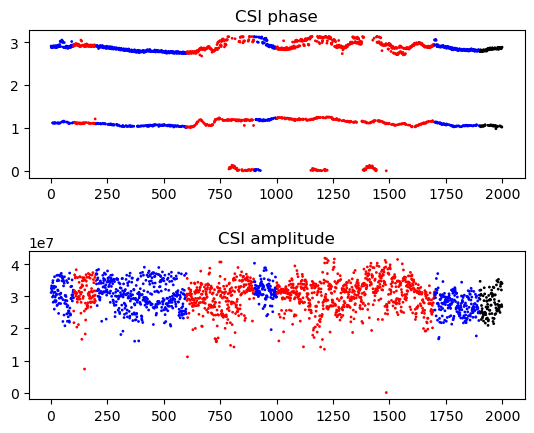

In [48]:
print(labels)
print(checked_label)
# show 18th subcarrier 
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
ax1.scatter(time_sequence, csi_phase[:,18],s = 1, c = colors)
ax1.set_title("CSI phase")
ax2.scatter(time_sequence, csi_amp[:,18],s = 1,c = colors)
ax2.set_title("CSI amplitude")
fig.subplots_adjust(hspace=0.5)
plt.show()

In [4]:
type(pred_label)

numpy.ndarray

In [6]:
import numpy as np
from numpy import convolve

k = 3 # filter size

# create a 1D array
x = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# add zeros to the beginning and end of the array
pad_size = (k - 1) // 2
padded = np.pad(x, pad_size, mode='constant', constant_values=0)

# define the filter kernel
kernel = np.ones(k) / k

# apply the mean filter
smoothed = convolve(padded, kernel, mode='valid')

print(smoothed)



[1.         2.         3.         4.         5.         6.
 7.         8.         9.         6.33333333]


In [46]:
moving_num +=1

# Test the svm in new data

In [1]:
def CSIextracter(folder,motion):
    #1. load CSI data and SVM model
#     movement_folder = '/Users/wanrylin/Master Programme/dataset/original data/movement'
#     folder = movement_folder
#     motion = 'walk'
    movement_listpath = os.listdir(folder)
    movement_listpath = [x for x in movement_listpath if motion in x]
    
    CSI_amp = []
    CSI_pha = []
    Time = []
    label = []
    # Load the csi sequence
    for moving_num in range(len(movement_listpath)):
        filename = folder + '/' + movement_listpath[moving_num]
        CSIdata = pd.read_csv(filename)
        CSI_array = CSIdata.values
        time_sequence = CSI_array[1:,0]
        csi_data_str = CSI_array[1:,1:]
        # change str into complex
        csi_data = np.zeros_like(csi_data_str, dtype=np.complex64)
        [row,col] = csi_data_str.shape
        for i in range(row):
            for j in range(col):
                element = csi_data_str[i,j]
                element = element.replace('i', 'j')
                csi_data[i,j] = complex(element)

        # revise time sequence
        peak = [ time_sequence[t] for t in range(1,len(time_sequence)-1) if time_sequence[t] > time_sequence[t-1] and time_sequence[t] > time_sequence[t+1]]
        peak = []
        for i in range(1,len(time_sequence)-1):
            if time_sequence[i] > time_sequence[i-1] and time_sequence[i] > time_sequence[i+1]:
                peak.append(i)
        for position in peak:
            time_sequence[int(position+1):] += 4096 
        time_sequence -= (time_sequence[0]-1)
        # check time sequence is it in order
        flag = 0
        for i in range(1,len(time_sequence)-1):
            if time_sequence[i] < time_sequence[i-1]: 
                flag = 1
                print("the %d in time sequence not in order",i)
                break
        Time.append(time_sequence)

        # get amplitude data only
        csi_amp = np.abs(csi_data)
        CSI_amp.append(csi_amp)

        # revise CSI phase data
        # phase correction from [IndoTrack]
        rx1 = csi_data[:,:57]
        rx2 = csi_data[:,57:]
        csi_data_adj = np.zeros(rx1.shape, dtype=complex)
        csi_data_ref_adj = np.zeros(rx2.shape, dtype=complex)
        alpha_sum = 0
        for jj in range(57):
            amp = np.abs(rx1[:,jj])
            alpha = np.min(amp[amp!=0])
            alpha_sum = alpha_sum + alpha
            csi_data_adj[:,jj] = np.abs(np.abs(rx1[:,jj]) - alpha) * np.exp(1j * np.angle(rx1[:,jj]))
        beta = 5000 * alpha_sum / 57 # 5000 is an experience value, it just need to be large enough
        for jj in range(57):
            csi_data_ref_adj[:,jj] = (np.abs(rx2[:,jj]) + beta) * np.exp(1j * np.angle(rx2[:,jj]))
        # Conjunction Multiply
        conj_mult = csi_data_adj * np.conj(csi_data_ref_adj)
        csi_revised = np.zeros(conj_mult.shape, dtype=complex)
        for j in range(57):
            for i in range(len(conj_mult)):
                z = conj_mult[i,j]
                if z.imag < 0:
                    csi_revised[i,j] = -1 * z.real + (-1j) * z.imag
                else:
                    csi_revised[i,j] = z           
        csi_phase = np.angle(csi_revised)
        CSI_pha.append(csi_phase)
        
        # generate the label for the motion
        file_name = os.path.basename(filename)
        name_list = file_name.split('_')
        if len(name_list) > 1:
            name_list = name_list[:-1]
            motion_label = '_'.join(name_list)
        else:
            motion_label = name_list[0]
        label.append(motion_label)
        
    return CSI_amp,CSI_pha,Time,label

In [2]:
def feature_generater(CSI_pha,Time):
    
    svm_folder = '/Users/wanrylin/Master Programme/dataset/movement detection/svm_model'
    # load svm model
    filename = svm_folder + '/pca_svm_model.joblib'
    svm = joblib.load(filename)
    filename = svm_folder + '/pca_scaler.joblib'
    scaler = joblib.load(filename)
    #3. movement period detection
    feature_num = 2
    dimension_num = 10
    # cut the csi sequence into frame with 1 second long and 0.5 interval
    sampling_rate = 200 # Hz
    frame_length = 1 # second
    frame = frame_length * sampling_rate
    interval_length = 0.5 # second
    interval = interval_length * sampling_rate
    
    # detection
    all_feature = np.zeros((1,20))
    for k in range(len(Time)):
        csi_phase = CSI_pha[k]
        time_sequence = Time[k]
        time_sequence = list(time_sequence)
        num = int((time_sequence[-1] - frame)/interval + 1) # number of frames
        start = 0 # initial boundry
        end = 150
        labels = np.zeros((len(time_sequence),))
        # prediction for each frame
        for i in range(num):
            #1. generate frame
            if (i * interval + 1) in time_sequence:
                start = int(time_sequence.index(i * interval + 1))
            else:
                start_time = np.min([x for x in time_sequence[start:start + 200] if x > (i * interval + 1)])
                start = int(time_sequence.index(start_time))
            if (i * interval + frame + 1) in time_sequence or (i * interval + frame + 1) > time_sequence[-1]:
                end = int(time_sequence.index(np.min([i * interval + frame + 1,time_sequence[-1]])))
            else:
                end_time = np.min([x for x in time_sequence[end:end + 200] if x > (i * interval + frame + 1)])
                end = int(np.min([time_sequence.index(end_time),len(time_sequence)]))
            phase = csi_phase[start:end]

            #2. Make predictions on the test set using the loaded model
            #(a) create csi feature
            # create a PCA object with 10 components
            pca = PCA(dimension_num)
            # fit the PCA object to the data and transform the data
            phase_pca = pca.fit_transform(phase)
            # iterate each component
            feature_matrix = np.zeros((feature_num, dimension_num))
            for j in range(dimension_num):
                pha_mean = np.mean(phase_pca[:, j])
                pha_var = np.var(phase_pca[:, j])
                sub_feature = np.array([pha_mean, pha_var])
                feature_matrix[:, j] = sub_feature
            feature_matrix = feature_matrix.T
            feature = feature_matrix.reshape(1,-1)   
            #(b) scale the feature
            feature_scaled = scaler.transform(feature)
#             #(c) predict label
#             pred_label = svm.predict(feature_scaled)
#             #(d) store the label in labels
#             if pred_label == 1:
#                 for n in range(start,end):
#                     labels[n] = 1

            all_feature = np.concatenate((all_feature, feature_scaled), axis=0)

    # save all feature
    all_feature = all_feature[1:, :]
        
    return all_feature

In [3]:
import pandas as pd
import numpy as np
import os

movement_folder = '/Users/wanrylin/Master Programme/dataset/original data/test/walking'
Motion = 'walk'
CSI_amp,CSI_pha,Time_sequence,motion_label = CSIextracter(movement_folder,Motion)

import joblib
from sklearn.decomposition import PCA

Feature_walk = feature_generater(CSI_pha,Time_sequence)
label_walk = np.ones((len(Feature_walk,)))

/Users/wanrylin/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SVC from version 1.1.3 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/wanrylin/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 1.1.3 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:
static_folder = '/Users/wanrylin/Master Programme/dataset/original data/test/static'
Motion = 'csv'
CSI_amp,CSI_pha,Time_sequence,motion_label = CSIextracter(static_folder,Motion)
Feature_static = feature_generater(CSI_pha,Time_sequence)
label_static = np.zeros((len(Feature_static,)))

/Users/wanrylin/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SVC from version 1.1.3 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/wanrylin/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 1.1.3 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [5]:
X_test_new = np.concatenate((Feature_static , Feature_walk),axis = 0)
y_test_new = np.concatenate((label_static, label_walk))

[0.9533132530120482, 0.8609865470852018, 1.0, 0.9253012048192771]
124
130
160
161
175
204
246
248
249
262
293
298
304
305
307
308
311
312
321
325
327
328
329
332
334
336
337
345
346
347
351
380
381
730
732
737
741
747
752
753
771
775
776
778
780
782
785
786
787
790
791
798
803
807
814
815
820
821
825
904
905
906


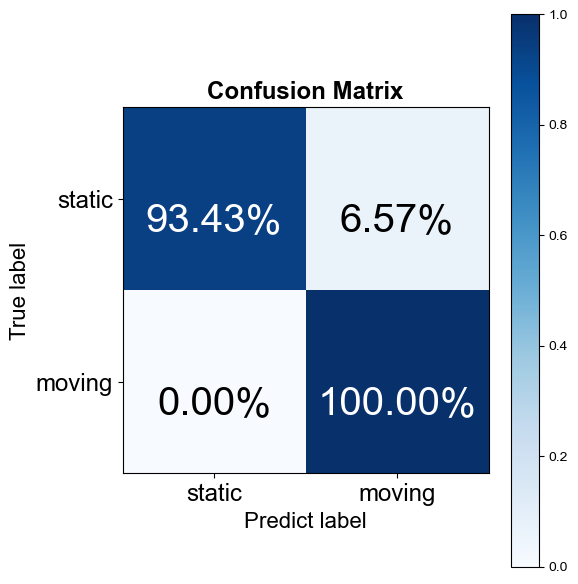

The accuracy of the model is 95.33%
The GMean of the model is 96.66%
The recall of the model is 95.33%
The precision of the model is 100.00%
The F1 of the model is 97.61%


In [72]:
test_pred = svc.predict(X_test_new)

# verify the performance
Accuracy = accuracy_score(y_test_new , test_pred)
Precision = precision_score(y_test_new , test_pred)
Recall = recall_score(y_test_new , test_pred)
F1_score = f1_score(y_test_new , test_pred)
print([Accuracy,Precision,Recall,F1_score])

for i in range(len(test_pred)):
    if test_pred[i] != y_test_new[i]:
        print(i)

Motion_label = ['static','moving']
pred_label = [Motion_label[int(x)] for x in test_pred]
true_label = [Motion_label[int(x)] for x in y_test_new]

confusion_m(pred_label, true_label,Motion_label)

In [58]:
movement_listpath = os.listdir(static_folder)
print(movement_listpath)

['bkbg2.csv', 'bkbg1.csv', 'stand_static_2_4.csv', 'sit_static_1_2.csv', 'lie_static_1.csv', 'lie_static_2.csv', 'sit_static_2_4.csv', 'stand_static_1_2.csv']


In [8]:
print(label_walk.shape)

(384,)


# get the feature distribution

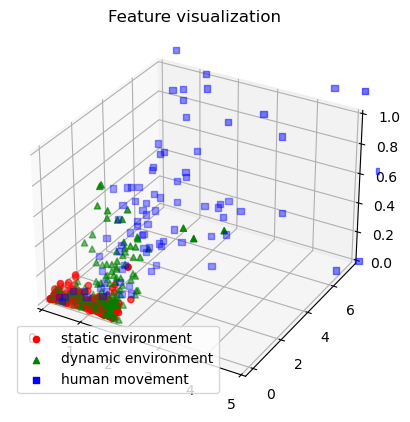

In [18]:
## load feature
e_static = pd.read_csv('/Users/wanrylin/Master Programme/dataset/movement detection/static/e_feature.csv')
p_static = pd.read_csv('/Users/wanrylin/Master Programme/dataset/movement detection/static/p_feature.csv')
dynamic = pd.read_csv('/Users/wanrylin/Master Programme/dataset/movement detection/dynamic/all_feature.csv')
e_static_array = e_static.values
p_static_array = p_static.values
dynamic_array = dynamic.values
dimension = [3,5,7]

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# generate data points
e_static_point = e_static_array[:,dimension]
p_static_point = p_static_array[:,dimension]
dynamic_point = dynamic_array[:,dimension]


# plot the points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(e_static_point[:,0], e_static_point[:,1], e_static_point[:,2], c='r', marker='o',label = 'static environment')
ax.scatter(p_static_point[:,0], p_static_point[:,1], p_static_point[:,2], c='g', marker='^',label = 'dynamic environment')
ax.scatter(dynamic_point[:,0], dynamic_point[:,1], dynamic_point[:,2], c='b', marker='s',label ='human movement')

ax.set_xlim(0, 5)
ax.set_zlim(0,1)
# set labels and title
plt.title('Feature visualization')
# show the legend
ax.legend()

# show the plot
plt.show()


In [21]:
dynamic_array.shape

(127, 20)